In [99]:
import torch
import torchaudio

import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.core.pylabtools import figsize

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt
from IPython.display import Audio as PlayAudio
import librosa
import numpy as np

2.6.0
2.6.0


In [100]:
class Obj12TET:
    NAMING_CONVENTIONS = {
        "EasternEurope": {
            "names": {'A', 'B', 'H', 'C', 'D', 'E', 'F', 'G'},
            "distances": {'A': 0, 'B': 1, 'H': 2, 'C': 3, 'D': 5, 'E': 7, 'F': 8, 'G': 10}
        },
        "English": {
            "names": {'A', 'B', 'C', 'D', 'E', 'F', 'G'},
            "distances": {'A': 0, 'H': 2, 'C': 3, 'D': 5, 'E': 7, 'F': 8, 'G': 10}
        }}
    POSSIBLE_CHROMATICS = {
        "none" : 0,
        "#": 1, "##": 2,
        "b": -1, "bb": -2,
    }
    MAX_NOTE_NUMB = 8  # Maximum number by the note (eg 'A8')

    def __init__(self, tuning=440, conv="EasternEurope"):
        self._NOTES_AND_DISTANCES = self.NAMING_CONVENTIONS[conv]
        self._A4_TUNING = tuning


In [101]:
class NoteTone(Obj12TET):
    def __init__(self, label, tuning=440, conv="EasternEurope"):
        super().__init__(tuning, conv)
        self._letter, self._number, self._chromatics = self.label_to_note_params(label)
        self._dist_from_A0 = self.calc_dist()
        self._frequency = self.calc_frequency()

    def calc_dist(self):
        letter_adjust = self._NOTES_AND_DISTANCES["distances"][self._letter]
        octaves = 12 * self._number
        chrom_adjust = self.POSSIBLE_CHROMATICS[self._chromatics]
        return letter_adjust + octaves + chrom_adjust

    def calc_frequency(self):
        exponent = self._dist_from_A0 / 12
        A0_freq = self._A4_TUNING / 16
        return A0_freq * pow(2, exponent)

    def label_to_note_params(self, label):
        letter = label[0]
        number = int(label[len(label) - 1])
        chromatics = "none"
        if len(label) == 3:
            chromatics = label[1]
        elif len(label) == 4:
            chromatics = label[1:2]
        return letter, number, chromatics

    def print(self):
        print(self._letter + self._chromatics + str(self._number))



In [102]:
A4 = NoteTone("B#2")
A4.print()


B#2


In [105]:
class Audio:
    def __init__(self, path):
        self.WAVE_FORM, self.SAMPLE_RATE = torchaudio.load(path)

    def plot_waveform(self, title="Waveform", ax=None):
        waveform = self.WAVE_FORM.numpy()
        num_channels, num_frames = waveform.shape
        time_axis = torch.arange(0, num_frames) / self.SAMPLE_RATE
        if ax is None:
            fig, ax = plt.subplots(num_channels, 1, figsize=(8, 2))
        ax.plot(time_axis, waveform[0], linewidth=1)
        ax.grid(True)
        ax.set_title(title)

    def play(self):
        return PlayAudio(self.WAVE_FORM.numpy(), rate = self.SAMPLE_RATE)

    def plot_spectogram(self, title=None, ax=None, y_label='freq_bin'):
        spectogram = T.Spectrogram(n_fft=512, normalized=True)
        spec = spectogram(self.WAVE_FORM)
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(6, 3))
        if title is not None:
            ax.set_title(title)
        ax.set_ylabel(y_label)
        data = librosa.power_to_db(spec[0])
        y = np.logspace(0, 3, data.shape[0])
        ax.imshow(
            data,
            origin='lower',
            aspect='auto',
            interpolation='nearest',
            extent=[0, data.shape[1], y[0], y[-1]]
        )
        ax.set_yscale('log')

    def plot_pitch(self, freq_high = 4000):
        waveform = self.WAVE_FORM
        sr = self.SAMPLE_RATE
        pitch = F.detect_pitch_frequency(waveform, sr, freq_high=freq_high)
        figure, axis = plt.subplots(1, 1)
        axis.set_title("Pitch Feature")
        axis.grid(True)

        end_time = waveform.shape[1] / sr
        time_axis = torch.linspace(0, end_time, waveform.shape[1])
        axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

        axis2 = axis.twinx()
        time_axis = torch.linspace(0, end_time, pitch.shape[1])
        axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

        axis2.legend(loc=0)

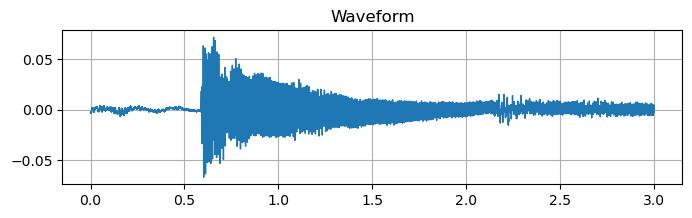

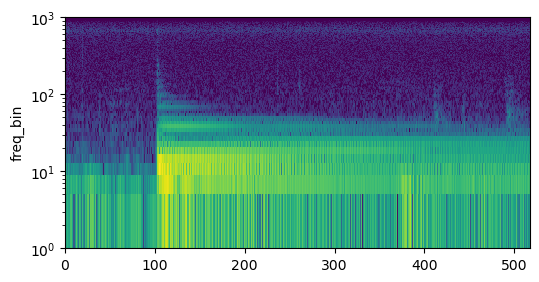

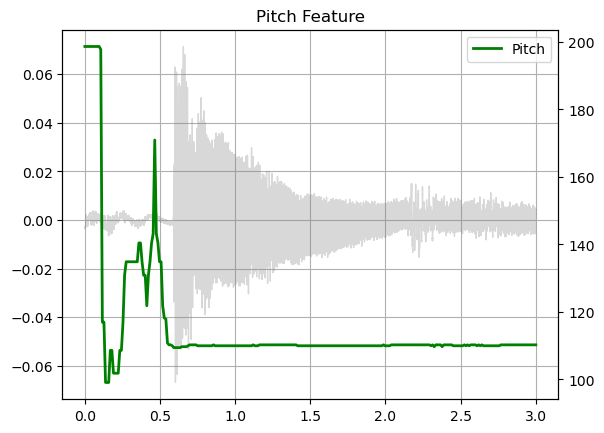

In [107]:
A2_PATH = "Raw_Audio_Data/A2/2.wav"
a2_tone = Audio(A2_PATH)
a2_tone.plot_waveform()
a2_tone.play()
a2_tone.plot_spectogram()
a2_tone.plot_pitch(200)